<a href="https://colab.research.google.com/github/iasonasxrist/ImageTranslation_pytorch/blob/main/4_Training_and_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Medical image translation with PyTorch**

Create a deep convolutional network for an image translation task with PyTorch from scratch and train it on a subset of the IXI dataset for a T1-w to T2-w transformation.


## **Training and Validation Data Setup**
This notebook deals with structural magnetic resonance (MR) images of the brain. Specifically, we will be dealing with two types of MR images: T1-weighted (T1-w) and T2-weighted (T2-w) MR images. Collecting these different types of images is time-consuming and therefore not always done. When a patient doesn’t have one of the two types of images, we can use deep learning to fill in the missing data. Here we will assume that a new patient will always have a T1-w image but not necessarily a T2-w image. However, we have access to a dataset of paired T1-w and T2-w images from a cohort of patients, and so we will create a CNN to learn how to transform the T1-w images to an (approximate) T2-w image based on these training pairs. Then we’ll be able to use an unseen patient’s T1-w image and generate an approximate T2-w image. While this approximate T2-w image wouldn’t be used for diagnostic purposes, the approximate image can be used as input to other image processing algorithms.

In this milestone we’ll get basic familiarity with handling the NIfTI file format—the file format in which the MR images are provided so that we can feed the images into a deep neural network. To do so, we’ll take an example image from the training set and extract, manipulate, and visualize the data.

In [ ]:
"""
Created on Fri Nov 12 15:46:50 2021

@author: iasonasxrist
"""
import sys
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
import random
import os
import torch
from torch import nn
from torch.utils.data.dataset import Dataset

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision.transforms import Compose
from typing import Callable, List, Optional, Tuple, Union

In [ ]:
from google.colab import drive
drive.mount('gdrive/')

In [ ]:
!nvidia-smi

In [ ]:
path = "/content/gdrive/MyDrive/Colab Notebooks/small"

t1_dir = os.path.join(path ,'t1')
t2_dir = os.path.join(path, 't2')

print(torch.__version__)

print(torch.cuda.is_available())

pv = sys.version_info
print('python version: {}.{}.{}'.format(pv.major, pv.minor, pv.micro))

%load_ext autoreload
%autoreload 2

print(t1_dir)
print(t2_dir)


t1_fns = glob(os.path.join(t1_dir,'*.nii*'))
t2_fns = glob(os.path.join(t2_dir,'*.nii*'))

t1_ex,t2_ex = nib.load(t1_fns[0]).get_fdata() , nib.load(t2_fns[0]).get_fdata()
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,7))
ax1.imshow(np.rot90(t1_ex[:,:,50]) , cmap='gray'); ax1.set_title('T1',fontsize=22);
ax2.imshow(np.rot90(t2_ex[:,:,50]), cmap='gray'); ax2.set_title('T2', fontsize=22);

In [ ]:
def glob_imgs(path: str, ext='*.nii*') -> List[str]:
    """ grab all `ext` files in a directory and sort them for consistency """
    fns = sorted(glob(os.path.join(path, ext)))
    return fns

class NiftiDataset(Dataset):
    """
    create a dataset class in PyTorch for reading NIfTI files
    Args:
        source_dir (str): path to source images
        target_dir (str): path to target images
        transform (Callable): transform to apply to both source and target images
        preload (bool): load all data when initializing the dataset
    """

    def __init__(self, source_dir:str, target_dir:str, transform:Optional[Callable]=None, preload:bool=True):
        self.source_dir, self.target_dir = source_dir, target_dir
        self.source_fns, self.target_fns = glob_imgs(source_dir), glob_imgs(target_dir)
        self.transform = transform
        self.preload = preload
        if len(self.source_fns) != len(self.target_fns) or len(self.source_fns) == 0:
            raise ValueError(f'Number of source and target images must be equal and non-zero')
        if preload:
            self.imgs = [(nib.load(s).get_data().astype(np.float32), 
                          nib.load(t).get_data().astype(np.float32))
                         for s, t in zip(self.source_fns, self.target_fns)]

    def __len__(self):
        return len(self.source_fns)

    def __getitem__(self, idx:int):
        if not self.preload:
            src_fn, tgt_fn = self.source_fns[idx], self.target_fns[idx]
            sample = (nib.load(src_fn).get_data(), nib.load(tgt_fn).get_data())
        else:
            sample = self.imgs[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        return sample



class BaseTransform:
    def __repr__(self): return f'{self.__class__.__name__}'


class ToTensor(BaseTransform):
    """ Convert images in sample to Tensors """
    def __call__(self, sample:Tuple[np.ndarray,np.ndarray]) -> Tuple[torch.Tensor,torch.Tensor]:
        src, tgt = sample
        return torch.from_numpy(src), torch.from_numpy(tgt)

    
class CropBase(BaseTransform):
    """ base class for crop transform """

    def __init__(self, out_dim:int, output_size:Union[tuple,int,list], threshold:Optional[float]=None):
        """ provide the common functionality for RandomCrop2D and RandomCrop3D """
        assert isinstance(output_size, (int, tuple, list))
        if isinstance(output_size, int):
            self.output_size = (output_size,)
            for _ in range(out_dim - 1):
                self.output_size += (output_size,)
        else:
            assert len(output_size) == out_dim
            self.output_size = output_size
        self.out_dim = out_dim
        self.thresh = threshold

    def _get_sample_idxs(self, img:np.ndarray) -> Tuple[int,int,int]:
        """ get the set of indices from which to sample (foreground) """
        mask = np.where(img >= (img.mean() if self.thresh is None else self.thresh))  # returns a tuple of length 3
        c = np.random.randint(0, len(mask[0]))  # choose the set of idxs to use
        h, w, d = [m[c] for m in mask]  # pull out the chosen idxs
        return h, w, d

    def __repr__(self):
        s = '{name}(output_size={output_size}, threshold={thresh})'
        d = dict(self.__dict__)
        return s.format(name=self.__class__.__name__, **d)

    
class RandomCrop3D(CropBase):
    """
    Randomly crop a 3d patch from a (pair of) 3d image
    Args:
        output_size (tuple or int): Desired output size.
            If int, cube crop is made.
    """

    def __init__(self, output_size:Union[tuple,int,list], threshold:Optional[float]=None):
        super().__init__(3, output_size, threshold)

    def __call__(self, sample:Tuple[np.ndarray,np.ndarray]) -> Tuple[np.ndarray,np.ndarray]:
        src, tgt = sample
        *cs, h, w, d = src.shape
        *ct, _, _, _ = tgt.shape
        hh, ww, dd = self.output_size
        max_idxs = (h-hh//2, w-ww//2, d-dd//2)
        min_idxs = (hh//2, ww//2, dd//2)
        s = src[0] if len(cs) > 0 else src  # use the first image to determine sampling if multimodal
        s_idxs = super()._get_sample_idxs(s)
        i, j, k = [i if min_i <= i <= max_i else max_i if i > max_i else min_i
                   for max_i, min_i, i in zip(max_idxs, min_idxs, s_idxs)]
        oh = 0 if hh % 2 == 0 else 1
        ow = 0 if ww % 2 == 0 else 1
        od = 0 if dd % 2 == 0 else 1
        s = src[..., i-hh//2:i+hh//2+oh, j-ww//2:j+ww//2+ow, k-dd//2:k+dd//2+od]
        t = tgt[..., i-hh//2:i+hh//2+oh, j-ww//2:j+ww//2+ow, k-dd//2:k+dd//2+od]
        if len(cs) == 0: s = s[np.newaxis,...]  # add channel axis if empty
        if len(ct) == 0: t = t[np.newaxis,...]
        return s, t



In [ ]:
def conv(i,o):
    
 return     (nn.Conv3d(i,o, 3 , padding=1 , bias = False),
            nn.BatchNorm3d(o),
            nn.ReLU(inplace=True))
    

def unet_block(i,m,o):
    return nn.Sequential(*conv(i,m),*conv(m,o))


class Unet(nn.Module):
    
    def __init__(self,s=32):
        
        super().__init__()
        self.start = unet_block(1,s,s)
        self.down1  = unet_block(s,2*s,2*s) 
        self.down2  = unet_block(2*s , 4*s , 4*s)
        self.bridge = unet_block(s*4,s*8,s*4)
        self.up2 = unet_block(s*8,s*4,s*2)
        self.up1 = unet_block(s*4,s*2,s)
        self.final = nn.Sequential(*conv(s*2,s),nn.Conv3d(s,1,1))


    def forward(self,x):
        
        r = [self.start(x)]
        r.append(self.down1(F.max_pool3d(r[-1],2)))
        r.append(self.down2(F.max_pool3d(r[-1],2)))
        x = F.interpolate(self.bridge(F.max_pool3d(r[-1],2)),size=r[-1].shape[2:])
        x = F.interpolate(self.up2(torch.cat((x,r[-1]),dim=1)),size=r[-2].shape[2:])
        x = F.interpolate(self.up1(torch.cat((x,r[-2]),dim=1)),size=r[-3].shape[2:])
        x = self.final(torch.cat((x,r[-3]),dim=1))
        return x  
        

In [ ]:
valid_split = 0.1
batch_size = 1
n_jobs = 8
n_epochs = 50



    
# set up training and validation data loader for nifti images
tmfs = Compose([RandomCrop3D((128,128,32)) , ToTensor()])


dataset = NiftiDataset(t1_dir , t2_dir , tmfs , preload=True) # set preload=False if you have limited CPU memory

num_train = len(dataset)
indices = list(range(num_train))
split = int(valid_split * num_train)


valid_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(valid_idx))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = DataLoader(dataset,sampler=train_sampler,batch_size=batch_size, num_workers=n_jobs,pin_memory=False)
valid_loader = DataLoader(dataset,sampler =valid_sampler,batch_size=batch_size,num_workers=n_jobs,pin_memory=False)

device = torch.device('cuda')
model = Unet()
model.cuda(device=device)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay = 1e-6)
criterion = nn.SmoothL1Loss()   # nn.MSELoss()


     
train_losses, valid_losses = [], []
n_batches = len(train_loader)

In [ ]:
# # model.load_state_dict(torch.load(path))
# plot = figure()
# plot.line(x='n_epochs' , y='t_losses', color='green', alpha=0.8 , legend_label='Train loss', line_width=2,
#  source=source)

# plot.line(x = 'n_epochs' , y='v_losses',color = 'red' , alpha = 0.8, legend_label ='Val loss',line_width=2,
#  source=source)



# doc = curdoc()
# # Add the plot to the current document
# doc.add_root(plot)

In [ ]:
for t in range(1, n_epochs + 1):
    # training
    t_losses = []
    model.train(True)
    for i, (src, tgt) in enumerate(train_loader):
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        out = model(src)
        loss = criterion(out, tgt)
        t_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    train_losses.append(t_losses)

    # validation
    v_losses = []
    model.train(False)
    with torch.set_grad_enabled(False):
        for src, tgt in valid_loader:
            src, tgt = src.to(device), tgt.to(device)
            out = model(src)
            loss = criterion(out, tgt)
            v_losses.append(loss.item())
        valid_losses.append(v_losses)

    if not np.all(np.isfinite(t_losses)): 
        raise RuntimeError('NaN or Inf in training loss, cannot recover. Exiting.')
    log = f'Epoch: {t} - Training Loss: {np.mean(t_losses):.2e}, Validation Loss: {np.mean(v_losses):.2e}'
    print(log)

    # new_data = {‘n_epochs’: [n_epoch],
    #         ‘trainlosses’: [t_losses],
    #         ‘vallosses’: [val_losses] }
    # doc.add_next_tick_callback(partial(update, new_data)) 

torch.save(model.state_dict(), 'trained.pth')

     

     

In [ ]:
plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, color='blue') 
plt.plot(valid_losses, color='red' )
plt.xlabel('Number of epoch')
plt.ylabel('Loss'); 
plt.title('Loss Function with L1 Regularization VS Epoch')


plt.subplot(1, 3, 2)
x = [i+1 for i in range(len(train_losses))]
y = train_losses;
plt.xlabel('Number of epoch')
plt.ylabel('Loss'); 
plt.plot(x, y);
plt.title("Training Average Loss")
# plt.subplot(1, 2, 2)
# plt.title("Validation: Area under the ROC curve")
# x = [val_interval * (i + 1) for i in range(len(metric_values))]
# y = metric_values
# plt.xlabel('epoch')
# plt.plot(x, y)
# plt.show()

plt.subplot(1, 3, 3)
plt.plot(valid_losses, color='red')
plt.xlabel('Number of epoch')
plt.ylabel('Loss');
plt.title('Validation Average Loss')
# set the ylim to watch the loss function in validation set
# plt.ylim([0,0.48])
# plt.xlim([30,50])

In [ ]:
# !pip install torchmetrics
# import torchmetrics
# acc = torchmetrics.Accuracy()
#  = torch.Tensor([out])
# acc(out,tgt)

# out = t1_ex.detach().numpy()
# tgt =  t1_ex,t2_exdetach().numpy()
out.shape

In [ ]:
#what's in parameters? 
print("Named Parameters")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

print("")
print("All Parameters")
        
for param in model.parameters():
    if param.requires_grad:
        print(param.shape)

In [ ]:
model.eval()
with torch.no_grad():
  out = model.forward(torch.from_numpy(t1_ex[None,None,...]).data.to(device=device, dtype=torch.float))
  # Use Tensor.cpu() to copy the tensor to host memory first. even though .cpu() is used

In [ ]:
out = out.cpu()

# t2_ex = t2_ex.cpu()
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,18))
ax1.imshow(out.squeeze()[:,62,:], cmap='gray', interpolation='gaussian'); ax1.set_title('Synthesized',fontsize=22); ax1.axis('off'); 
ax2.imshow(t2_ex[:,62,:], cmap='gray', interpolation='gaussian'); ax2.set_title('Truth',fontsize=22); ax2.axis('off');

"""
interpolation = ['none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 
                'hamming', 'hermite', 'kaiser', 'quadric', 'catrom',  'bessel', 
                'mitchell', 'sinc', 'lanczos', 'blackman','gaussian','hanning']
"""

out.type()

## **An example to make clear the essence of fine-tuning in deep learning.**

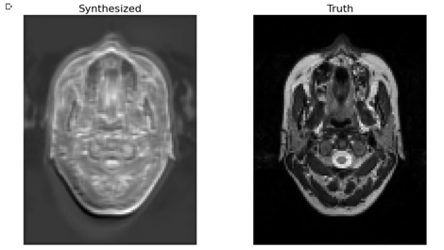



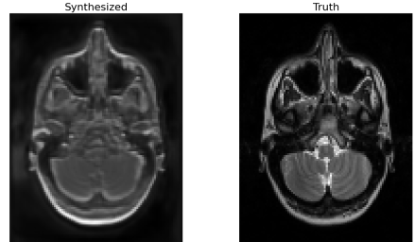

image.png

## The upper example has 12 workers in contrary with bottom example which have only 8 workers.
## We can easily observe the difference into the training. So, the SNR of image is completely different.